script for keeping track of changes and things done

In [1]:
# -- Libararies  
import os
import sys
import pickle
import torch

# for SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi import inference
from sbi.inference.base import infer
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.types import Array, OneOrMore, ScalarFloat

from matplotlib import pyplot as plt

import numpy as np
from numpy import cov
from numpy.linalg import det, norm # determinant, norm (used to calculate 'euclidean' distance)

import random
from numpy.random import normal
import matplotlib.pyplot as plt
from seaborn import pairplot
from seaborn import jointplot
import pandas as pd
from parflowio.pyParflowio import PFData
# import pygmmis <- This was the default but it doesn't work very well
from sklearn.mixture import GaussianMixture as GMM
import sys
import os
from datetime import datetime

# for machine learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Independent, Uniform
from torch.distributions.log_normal import LogNormal

# for scaling
from sklearn.preprocessing import MinMaxScaler

# for stats
# from assessutils import compute_stats
import re
from scipy.stats import mode

# helpers
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/03_sbi_lstm/')
from sbi_build import simulate




/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Old method for reading in data from simulator 
* Need to change so that this takes some set of forward simulations at a random subset of parameters to generate an array of 'probable' outputs

In [2]:
# function for retrieving data
def getData(sub, sub_sub, sbi_dir):
    '''
    function for retrieving data, and data to plot in time series 
    '''
    sbi_dir_sub = f'{sbi_dir}{sub}/'
    sbi_dir_sub_sub = f'{sbi_dir_sub}{sub_sub}/'


    with open(sbi_dir+'DataX_test.pkl', 'rb') as fp:
        DataX_test = pickle.load(fp)

    with open(sbi_dir+'test_params.pkl', 'rb') as fp:
        test_params = pickle.load(fp)

    with open(sbi_dir+'lstm_out_list.pkl', 'rb') as fp:
        lstm_out_list = pickle.load(fp)

    with open(sbi_dir_sub_sub+'y_hat_full.pkl', 'rb') as fp:
        y_hat = pickle.load(fp)[0,:]
    #     print(y_hat)

    with open(sbi_dir_sub_sub+'seriesarr.pkl', 'rb') as fp:
        seriesarr = pickle.load(fp)
    
    minarr = torch.min(torch.min(seriesarr, dim=2)[0], dim=1)[0].detach().numpy()
    maxarr = torch.max(torch.max(seriesarr, dim=2)[0], dim=1)[0].detach().numpy()
    meanarr = torch.mean(torch.mean(seriesarr, dim=2), dim=1).detach().numpy()

    y_hat_plot = y_hat.detach().numpy()
    
    return minarr, maxarr, meanarr, y_hat_plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

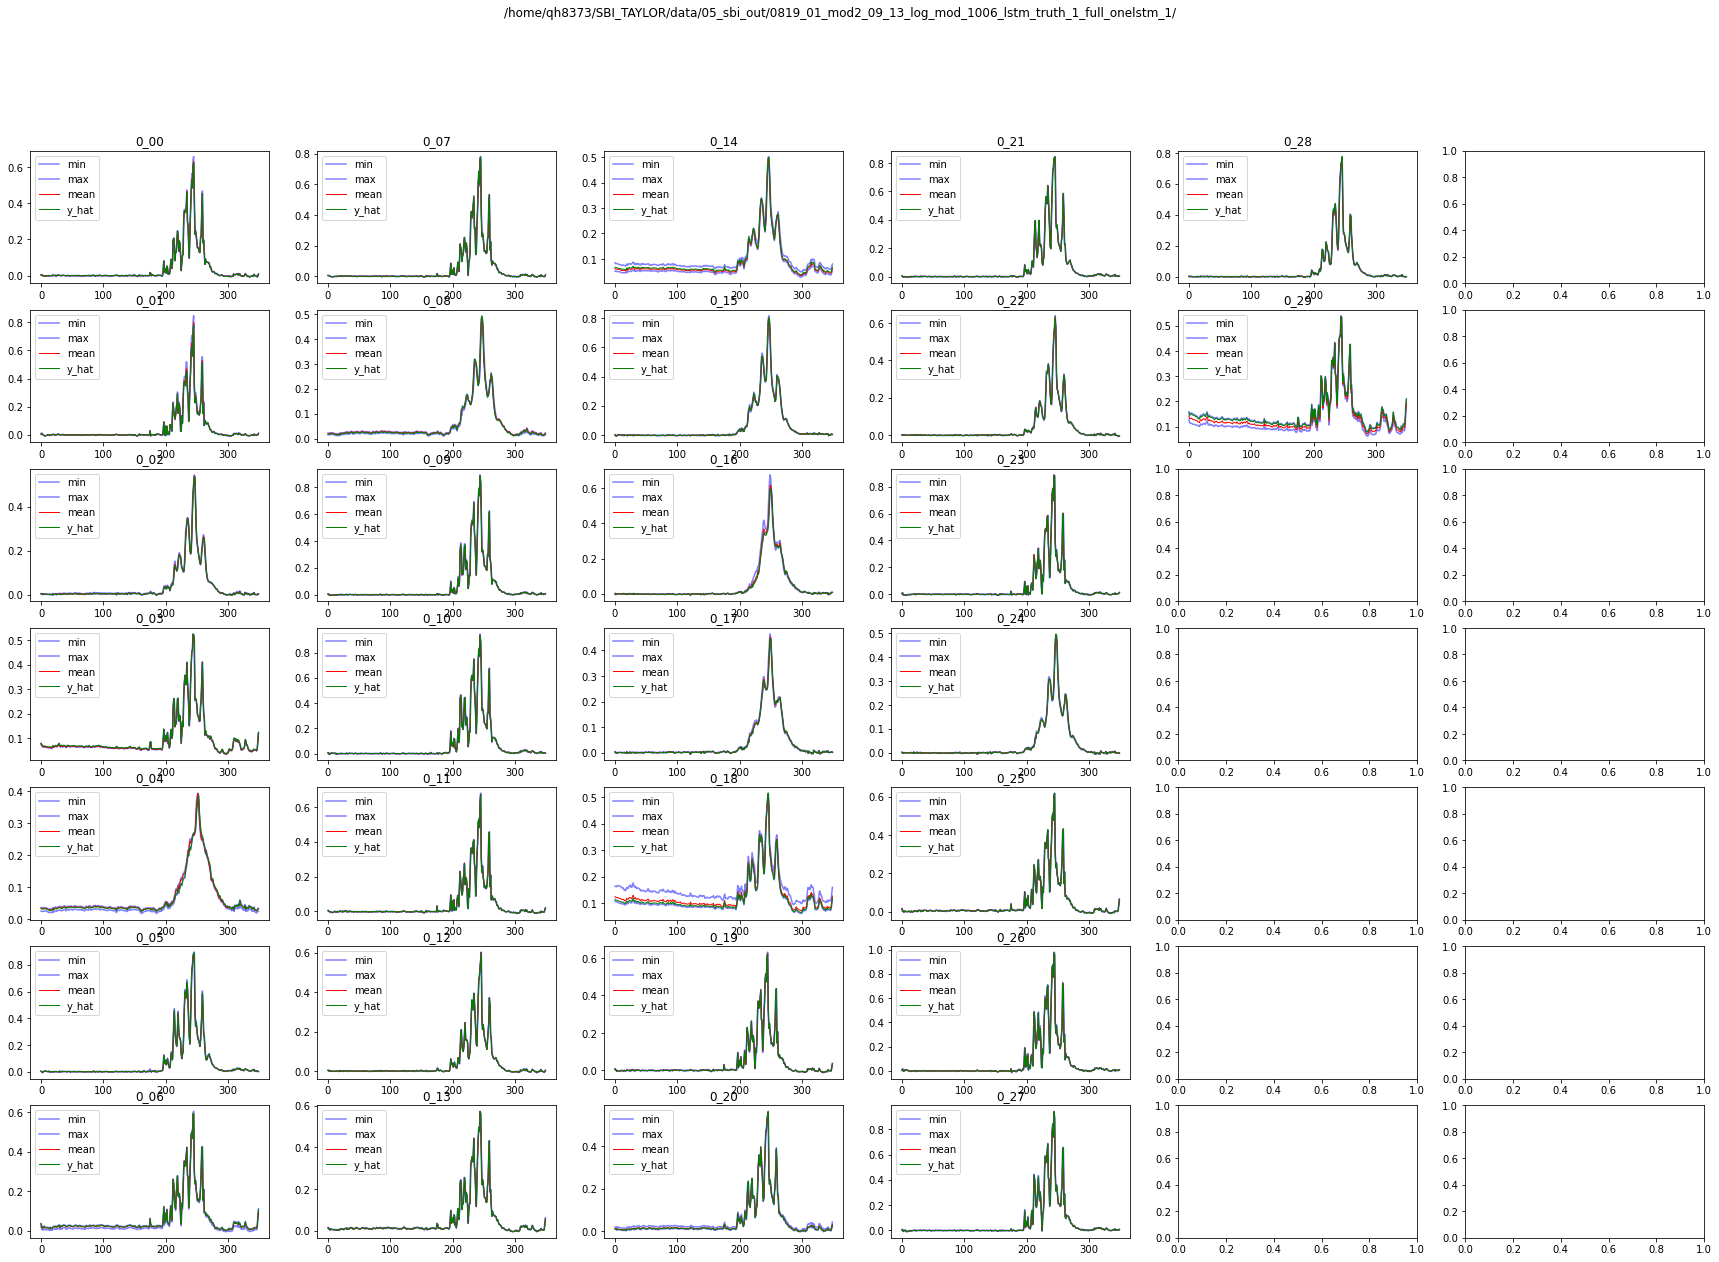

In [17]:
sub = 0
sub_sub_num = 30
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_[ 9 10]'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_embed_MLP_2'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_embed_MLP_4'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_full'

# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_full_onelstm_1

sbi_run  = '0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_full_onelstm_1'
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/{sbi_run}/'


# read in 

try:
    os.mkdir(save_dir)
except:
    print('warning: file exists')
    pass

try:
    os.mkdir(f'{save_dir}{sub}/')
except:
    print('warning: file exists')
    pass

div = 4
dim1, dim2 = int(sub_sub_num/div), int(sub_sub_num/div)-1
fig, axs = plt.subplots(dim1, dim2, figsize=(30, 20))

i, j = 0, 0
for k in range(sub_sub_num):
    
    if (k/dim1 == int(k/dim1)) and (k != 0):
        i = 0
        j = j + 1
    
    sub_sub = "{:02d}".format(k)
    
    minarr, maxarr, meanarr, y_hat_plot = getData(sub, sub_sub, sbi_dir)
    
    axs[i,j].plot(minarr, color='blue', alpha=0.5, label='min')
    axs[i,j].plot(maxarr, color='blue', alpha=0.5, label='max')
    axs[i,j].plot(meanarr, color='red', linewidth=1, label='mean')
    axs[i,j].plot(y_hat_plot, color='green', linewidth=1, label='y_hat')
    axs[i,j].set_title(f'{sub}_{sub_sub}')
    axs[i,j].legend()
    
    i = i + 1

# plt.plot(minarr, color='blue', alpha=0.5, label='min')
# plt.plot(maxarr, color='blue', alpha=0.5, label='max')
# plt.plot(meanarr, color='red', linewidth=1, label='mean')
# plt.plot(y_hat_plot, color='green', linewidth=1, label='y_hat')
fig.suptitle(sbi_dir)
fig.savefig(f'{save_dir}{sub}/'+'hydrograph.png')
fig.savefig(f'{save_dir}{sub}/'+'hydrograph.eps', format='eps')
plt.show()

### Plotting the 'efficacy' of the parameter estimation

In [3]:
def getDataCov(sbi_dir, sub, sub_sub_int):
    '''
    ;;;'''
    sbi_dir_sub = f'{sbi_dir}{sub}/'
    sub_sub = "{:02d}".format(sub_sub_int)
    sbi_dir_sub_sub = f'{sbi_dir_sub}{sub_sub}/'

    
    with open(sbi_dir_sub_sub+'log_probability.pkl', 'rb') as fp:
        log_probability = pickle.load(fp)

    with open(sbi_dir_sub_sub+'posterior_samples.pkl', 'rb') as fp:
        posterior_samples = pickle.load(fp)
        
    with open(sbi_dir+'test_params.pkl', 'rb') as fp:
        test_params = pickle.load(fp)
    
    # detach posterior samples
    posterior_samples = posterior_samples.detach().numpy()
    log_probability = log_probability.detach().numpy()
    
    # Summary statistics of param and the mean of those sampled
#     print(sub_sub_int)
    test_param = test_params.detach().numpy()[sub_sub_int,:]
    mean_param = posterior_samples.mean(axis=0)
    median_param = np.quantile(posterior_samples, q=0.5, axis=0)

    # covariance of the distribution
    cov_sample = cov(posterior_samples.T)
    # determinant of the distribution
    det_sample = det(cov_sample)
    
    # diagonal varaince
    var_param1, var_param2 = cov_sample[0,0], cov_sample[1,1]
    
    # off diagonal variance
    var_12, var_21 = cov_sample[0,1], cov_sample[0,1]
    
    # mismatch data
    theta_mu_diff_param1, theta_mu_diff_param2 = abs(test_param[0]-mean_param[0]), abs(test_param[1]-mean_param[1])
    theta_med_diff_param1, theta_med_diff_param2 = abs(test_param[0]-median_param[0]), abs(test_param[1]-median_param[1])
    
    # normalized mismatch
    var_mu_norm_param1, var_mu_norm_param2 = theta_mu_diff_param1/var_param1, theta_mu_diff_param2/var_param2
    var_med_norm_param1, var_med_norm_param2 = theta_med_diff_param1/var_param1, theta_med_diff_param2/var_param2
    
    out_dict = {'covariance' : cov_sample, 
                'determinant' : det_sample,
                'true param' : test_param,
                'mean param' : mean_param,
                'median_param' : median_param,
                'dia var 11' : var_param1,
                'dia var 22' : var_param2,
                'mismatch, mu, param1' : theta_mu_diff_param1,
                'mismatch, mu, param2' : theta_mu_diff_param2,
                'mismatch, med, param1' : theta_med_diff_param1,
                'mismatch, med, param2' : theta_med_diff_param2,
                'norm mismatch, mu, param1' : var_mu_norm_param1,
                'norm mismatch, mu, param2' : var_mu_norm_param2,
                'norm mismatch, med, param1' : var_med_norm_param1,
                'norm mismatch, med, param2' : var_med_norm_param2}
    
    return out_dict

In [4]:
# Runs

# ParFlwo Truth Base Case: (sim = 3), num=18
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_[ 9 10]'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_embed_MLP_2'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_embed_MLP_4'
# '0819_01_mod2_09_13_log_mod_09_14_log_mod_2_full'

# LSTM Truth base Case: (sim =1), num = 30
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1_full_onelstm_1

# LSTM Truth Multiple Base Case  (sim=10), num=30
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_[ 9 10]_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1006_lstm_truth_1-MULTIPLE_full_onelstm_1

# LSTM Truth Ensemble Multiple Base Case (sim=10), num=30
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_full_onelstm_1
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_embed_MLP_4_onelstm_1
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_embed_MLP_2_onelstm_1
# 0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_[ 9 10]_onelstm_1


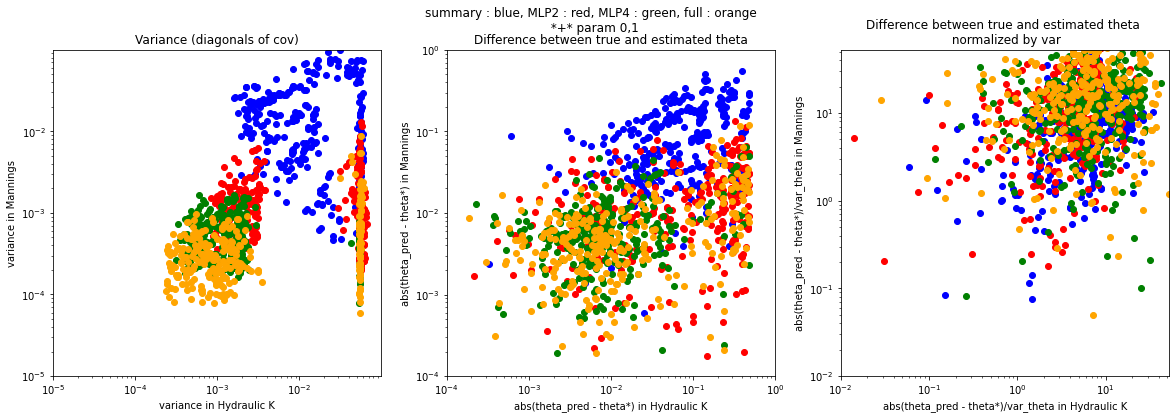

In [5]:
sub_num = 10 # the total number of replicate posteriors
sub_sub_num = 30 # the total number of truths to test


sbi_dir_list = ['/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_[ 9 10]_onelstm_1/',
            '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_embed_MLP_2_onelstm_1/',
            '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_embed_MLP_4_onelstm_1/',
            '/home/qh8373/SBI_TAYLOR/data/05_sbi_out/0819_01_mod2_09_13_log_mod_1007_lstm_truth_ensemble_1_full_onelstm_1/']





label_list = ['summary', 'MLP2', 'MLP4', 'full']
col_list = ['blue', 'red', 'green', 'orange']


fig, axs = plt.subplots(1, 3, figsize=(20,6))

max_var_param1, max_var_param2 = 0,0
max_theta_mu_diff_param1, max_theta_mu_diff_param2 = 0,0
max_var_mu_norm_param1, max_var_mu_norm_param2 = 0,0


# need to harvest so that we can plot the determinants, very important...
# dimensions ((num samples) sub_sub_num, (num_runs) sub_num, (num_types) len(sbi_dir_list), (num_metrics) 8)
    # metrics (euc_dist, var_param1, var_param2, theta_mu_diff_param1, theta_mu_diff_param2, 
    #     var_mu_norm_param1, var_mu_norm_param2, det_sample)
out_arr = np.empty((sub_sub_num, sub_num, len(sbi_dir_list), 8))
# loop through all the different model results
for z in range(len(sbi_dir_list)):
    sbi_dir = sbi_dir_list[z]
    col = col_list[z]
    label = label_list[z]
    # loop through all repetitions of replicate posteriors
    for sub in range(sub_num):
        # loop through all truths
        for sub_sub_int in range(sub_sub_num):
            # the daata read for specific iteration
            out_dir = getDataCov(sbi_dir, sub, sub_sub_int)
            
            # calculate distances...
            test_param, mean_param = out_dir['true param'], out_dir['mean param']
            euc_dist = norm(test_param-mean_param)
#             print(euc_dist)
            out_arr[sub_sub_int, sub, z, 0] = euc_dist
                   
            # make an assertion about marker based on if parameter is in / out of sample
            # if taken from 'out of sample', so to speak
            if (max(test_param) == 1) or min(test_param) == 0:
#                 print(test_param)
                markerstyle = '+'
            else:
                markerstyle = 'o'
            
            
            # ------
            # plot variance
            # ------
            var_param1, var_param2 = out_dir['dia var 11'], out_dir['dia var 22']
            out_arr[sub_sub_int, sub, z, 1:3] = np.array([var_param1, var_param2])

            # set minmax
            if var_param1.max() > max_var_param1:
                max_var_param1 = var_param1.max()
            if var_param2.max() > max_var_param2:
                max_var_param2 = var_param2.max()
            # scatter plot
            axs[0].scatter(var_param1, var_param2, color=col, label=label, marker=markerstyle)

            # ------
            # plot theta difference 
            # ------
            theta_mu_diff_param1, theta_mu_diff_param2 = out_dir['mismatch, mu, param1'], out_dir['mismatch, mu, param2']
            out_arr[sub_sub_int, sub, z, 3:5] = np.array([theta_mu_diff_param1, theta_mu_diff_param2])
                   
            # set minmax
            if theta_mu_diff_param1.max() > max_theta_mu_diff_param1:
                max_theta_mu_diff_param1 = theta_mu_diff_param1.max()
            if theta_mu_diff_param2.max() > max_theta_mu_diff_param2:
                max_theta_mu_diff_param2 = theta_mu_diff_param2.max()
            # scatter plot
            axs[1].scatter(theta_mu_diff_param1, theta_mu_diff_param2, color=col, label=label, marker=markerstyle)          
#             if z == 3:
#                 print(sub, sub_sub_int)
#                 print('true')
#                 print(test_param)
#                 print('mean')
#                 print(mean_param)
#                 print('difference between K, M')
#                 print(theta_mu_diff_param1, theta_mu_diff_param2)
#                 print('\n')


            # ------
            # normalized theta difference 
            # ------
            var_mu_norm_param1, var_mu_norm_param2 = out_dir['norm mismatch, mu, param1'], out_dir['norm mismatch, mu, param2']
            out_arr[sub_sub_int, sub, z, 5:7] = np.array([var_mu_norm_param1, var_mu_norm_param2])
                   
            # set minmax
            if var_mu_norm_param1.max() > max_var_mu_norm_param1:
                max_var_mu_norm_param1 = var_mu_norm_param1.max()
            if var_mu_norm_param2.max() > max_var_mu_norm_param2:
                max_var_mu_norm_param2 = var_mu_norm_param2.max()
            # plt var
            axs[2].scatter(var_mu_norm_param1, var_mu_norm_param2, color=col, label=label,marker=markerstyle)

            
            
            # ------
            # determinant
            # ------
            det_sample = out_dir['determinant']
            out_arr[sub_sub_int, sub, z, 7] = det_sample
                   
            
axs[0].set_title('Variance (diagonals of cov)')
axs[0].set_xlabel('variance in Hydraulic K')
axs[0].set_ylabel('variance in Mannings')
# axs[0].axis('equal')
axs[0].set_xlim(1e-05, max(max_var_param1, max_var_param2))
axs[0].set_ylim(1e-05, max(max_var_param1, max_var_param2))
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].set_title('Difference between true and estimated theta')
axs[1].set_xlabel('abs(theta_pred - theta*) in Hydraulic K')
axs[1].set_ylabel('abs(theta_pred - theta*) in Mannings')
axs[1].set_xlim(1e-04, 1)
axs[1].set_ylim(1e-04, 1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[2].set_title('Difference between true and estimated theta \n normalized by var')
axs[2].set_xlabel('abs(theta_pred - theta*)/var_theta in Hydraulic K')
axs[2].set_ylabel('abs(theta_pred - theta*)/var_theta in Mannings')
axs[2].set_xlim(1e-02, max(max_var_mu_norm_param1, max_var_mu_norm_param1))
axs[2].set_ylim(1e-02, max(max_var_mu_norm_param1, max_var_mu_norm_param1))
axs[2].set_xscale('log')
axs[2].set_yscale('log')

fig.suptitle('summary : blue, MLP2 : red, MLP4 : green, full : orange \n *+* param 0,1')
# fig.savefig(f'{save_dir}{sub}/'+'param_statistics_relation.png')
# fig.savefig(f'{save_dir}{sub}/'+'hydrograph.eps', format='eps')
plt.show()
plt.close()

            # print(cov_sample)
            # print(det_sample)
            # print(var_norm_param1)
            # print(var_norm_param2)

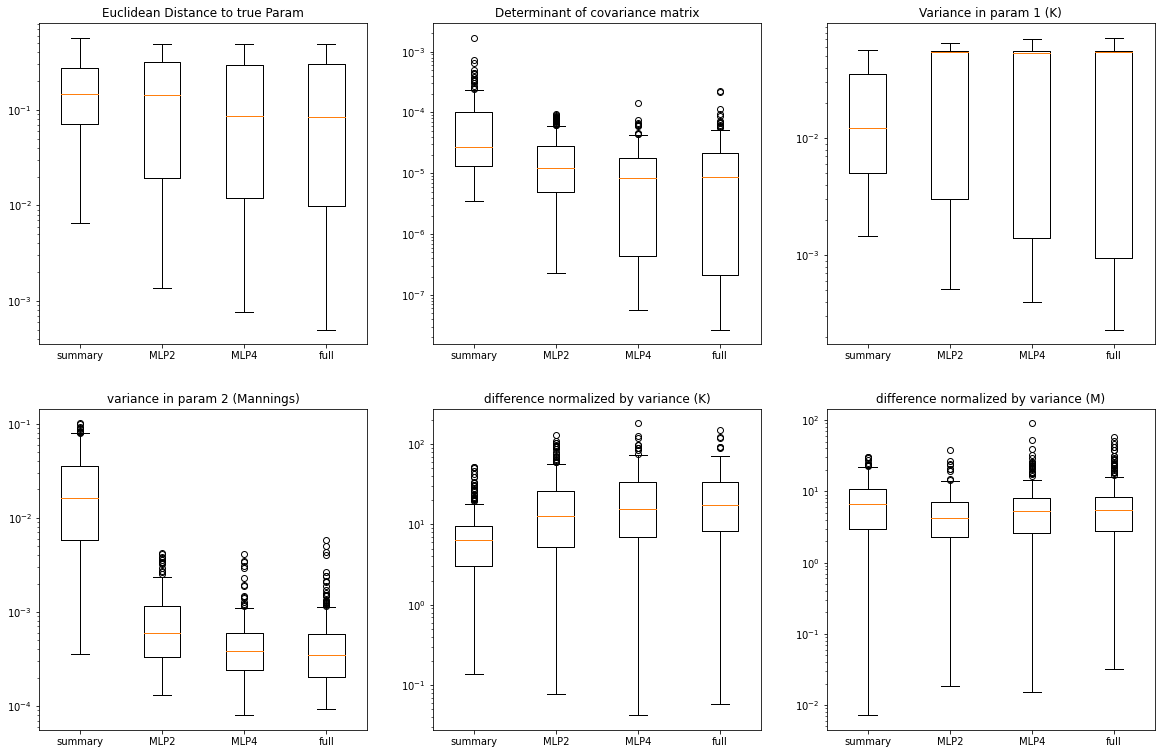

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(20,13))

label_list = ['summary', 'MLP2', 'MLP4', 'full']
col_list = ['blue', 'red', 'green', 'orange']


new_out_dir = np.concatenate((out_arr[:,0,:,:], out_arr[:,1,:,:], out_arr[:,2,:,:], out_arr[:,3,:,:], 
                             out_arr[:,4,:,:], out_arr[:,5,:,:], out_arr[:,6,:,:], out_arr[:,7,:,:], 
                             out_arr[:,8,:,:], out_arr[:,9,:,:]),
                             axis=0)
axs[0,0].set_title('Euclidean Distance to true Param')
axs[0,0].boxplot(new_out_dir[:,:,0])

axs[0,1].set_title('Determinant of covariance matrix')
axs[0,1].boxplot(new_out_dir[:,:,-1])

axs[0,2].set_title('Variance in param 1 (K)')
axs[0,2].boxplot(new_out_dir[:,:,1])

axs[1,0].set_title('variance in param 2 (Mannings)')
axs[1,0].boxplot(new_out_dir[:,:,2])
s
axs[1,1].set_title('difference normalized by variance (K)')
axs[1,1].boxplot(new_out_dir[:,:,-2])

axs[1,2].set_title('difference normalized by variance (M)')
axs[1,2].boxplot(new_out_dir[:,:,-3])

for j in range(2):
    for k in range(3):
        axs[j, k].set_xticklabels(['summary', 'MLP2', 'MLP4', 'full'])
        axs[j, k].set_yscale('log')
    
plt.show()
# out_arr[17,0,0,:]

In [37]:
print(out_arr.shape)
print(np.concatenate((out_arr[:,0,:,:], out_arr[:,1,:,:], out_arr[:,2,:,:]), axis=0).shape)


(18, 3, 4, 8)
(54, 4, 8)


In [80]:
# from conversation with Peter
# 1. covariance matrix : https://numpy.org/doc/stable/reference/generated/numpy.cov.html
# https://towardsdatascience.com/5-things-you-should-know-about-covariance-26b12a0516f1
# 2. http://www.cs.utah.edu/~tch/CS4640F2019/resources/A%20geometric%20interpretation%20of%20the%20covariance%20matrix.pdf
# 3. determinant: https://numpy.org/doc/stable/reference/generated/numpy.linalg.det.html

# from numpy import cov
# from numpy.linalg import det

# cov_sample = cov(posterior_samples.T)
# print(cov_sample, '\n')
# det_sample = det(cov_sample)
# print(det_sample)

[[ 2.57781885e-04 -7.52167415e-06]
 [-7.52167415e-06  1.73645176e-04]] 

4.470600517537963e-08
